# Deep Learning Portfolio 3

|Name|Github|Kaggle|
|----|------|------|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|
|Michal Reszka-Gniecki|Ckires|michalreszkagniecki|

## Table of Contents
- [Data Overview](#data-overview)
- [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Visualiseren](#visualiseren)
- [Feature Engineering](#feature-engineering)
    - [Analysis](#analysis)
- [Modeling](#modeling)
    - [Objectdetectie](#Model1)
    - [Ondertiteling van afbeeldinge](#Model2)
    - [Beeldgeneratie](#Model3)
    - [Implementatie](#Model4)
- [Results](#results)
    - [Scores](#scores)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)
- [Submission functie](#Submission-functie)
- [HTML functie](#HTML-functie)

In [ ]:
# !pip install keras-tuner --upgrade
# !pip install wordcloud
# !pip install tqdm


In [12]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Data Overview

In [13]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data importeren

In [14]:
img_train = "/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Train"
img_test = "/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Test"


In [15]:
sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 3 Datasets/submission_example.csv')

## Exploratory Data Analysis

#### Train data

In [100]:
# ImageDataGenerator aanmaken
datagen = ImageDataGenerator(rescale=1./255)  # normaliseer de beelden

# Laad de data automatisch uit submappen
train_data = datagen.flow_from_directory(
    img_train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
print("Klassen en hun indexen:", train_data.class_indices)

Found 2145 images belonging to 2 classes.
Klassen en hun indexen: {'images': 0, 'labels': 1}


#### Test data

In [99]:
test_data = datagen.flow_from_directory(
    img_test,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
print("Klassen en hun indexen:", test_data.class_indices)


Found 537 images belonging to 1 classes.
Klassen en hun indexen: {'images': 0}


## Voorbeeld afbeeldingen

### Train afbeeldingen

In [23]:
def toon_afbeeldingen_uit_batch(data, num_images=6):
    """
    Toont een aantal afbeeldingen uit een batch van een ImageDataGenerator.

    Parameters:
    - data: de ImageDataGenerator (flow_from_directory)
    - num_images: het aantal afbeeldingen om te tonen
    """
    # Haal een batch op
    images, labels = next(data)

    # Plot de afbeeldingen
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


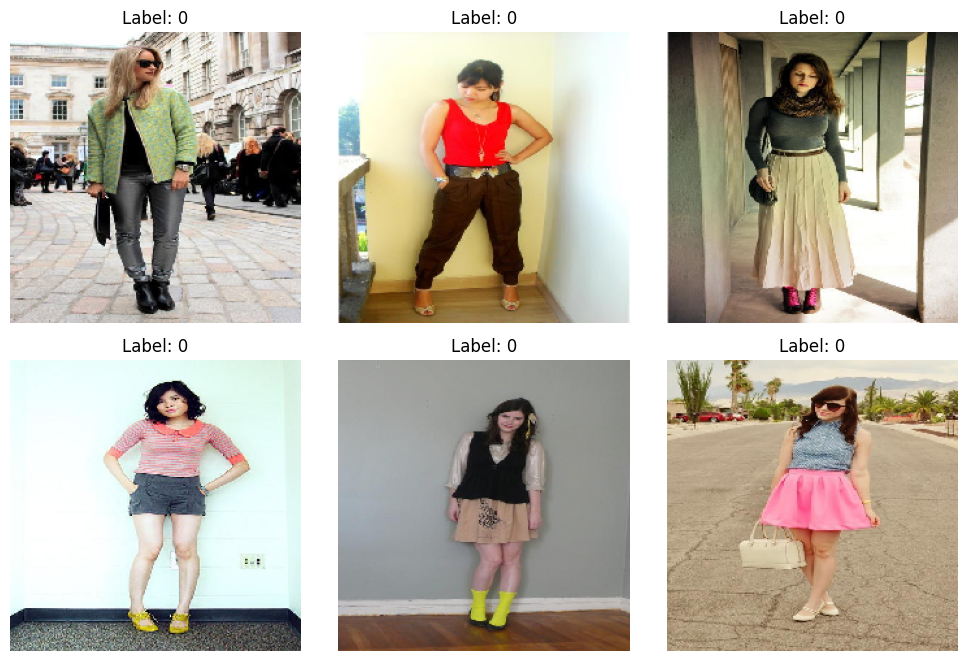

In [26]:
train_data_show = toon_afbeeldingen_uit_batch(train_data, num_images=6)
train_data_show

### Test afbeeldingen

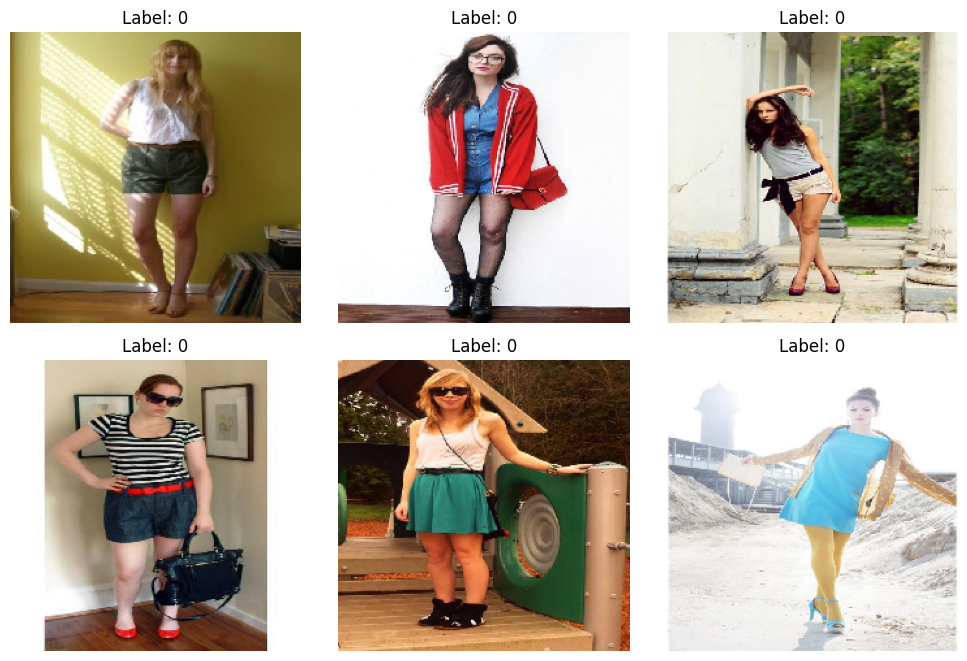

In [27]:
test_data_show = toon_afbeeldingen_uit_batch(test_data, num_images=6)
test_data_show

## Breedte & Hoogte verdeling

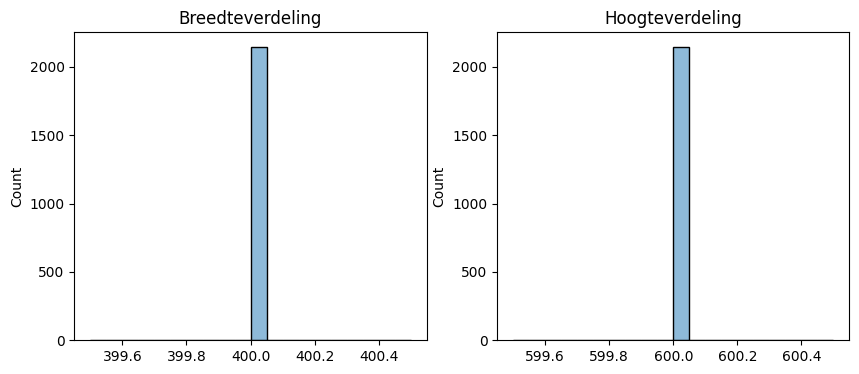

In [29]:
def verzamel_afmetingen(train_dir):
    sizes = []
    for label in os.listdir(train_dir):
        label_path = os.path.join(train_dir, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(label_path, img_name)
                    try:
                        with Image.open(img_path) as img:
                            sizes.append(img.size)  # (width, height)
                    except:
                        continue
    return sizes

afmetingen = verzamel_afmetingen(img_train)

# Visualiseer

widths = [s[0] for s in afmetingen]
heights = [s[1] for s in afmetingen]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=20, kde=True)
plt.title("Breedteverdeling")

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=20, kde=True)
plt.title("Hoogteverdeling")
plt.show()



## Controle op corrupte afbeeldingen

In [33]:
def controleer_corruptie(data):
    fouten = []
    for root, dirs, files in os.walk(data):
        for name in files:
            if name.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, name)
                try:
                    with Image.open(path) as img:
                        img.verify()  # check corruptie
                except Exception as e:
                    fouten.append(path)
    return fouten

corrupt = controleer_corruptie(img_train)
print(f"Corrupt of onleesbare afbeeldingen gevonden: {len(corrupt)}")


Corrupt of onleesbare afbeeldingen gevonden: 0


## Voorbeeldbeelden met kleurverdeling

In [ ]:
images_dir = img_train + '/images'

In [77]:
def toon_images_met_histogram(map_pad, aantal=3):
    # Pak alle afbeelding-bestanden in de map
    image_files = [f for f in os.listdir(map_pad) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if len(image_files) < aantal:
        print(f"Niet genoeg afbeeldingen in de map ({len(image_files)} gevonden, {aantal} gevraagd).")
        return

    # Kies random aantal afbeeldingen
    gekozen = random.sample(image_files, aantal)

    plt.figure(figsize=(12, 4 * aantal))

    for i, fname in enumerate(gekozen):
        path = os.path.join(map_pad, fname)
        img = cv2.imread(path)
        if img is None:
            print(f"Kan {fname} niet laden!")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        r, g, b = cv2.split(img)

        # Toon afbeelding
        plt.subplot(aantal, 2, i*2 + 1)
        plt.imshow(img)
        plt.title(fname)
        plt.axis('off')

        # Toon histogram
        plt.subplot(aantal, 2, i*2 + 2)
        plt.hist(r.ravel(), bins=256, color='r', alpha=0.5, label='Rood')
        plt.hist(g.ravel(), bins=256, color='g', alpha=0.5, label='Groen')
        plt.hist(b.ravel(), bins=256, color='b', alpha=0.5, label='Blauw')
        plt.title("RGB Histogram")
        plt.xlabel("Pixelwaarde")
        plt.ylabel("Aantal pixels")
        plt.legend()

    plt.tight_layout()
    plt.show()


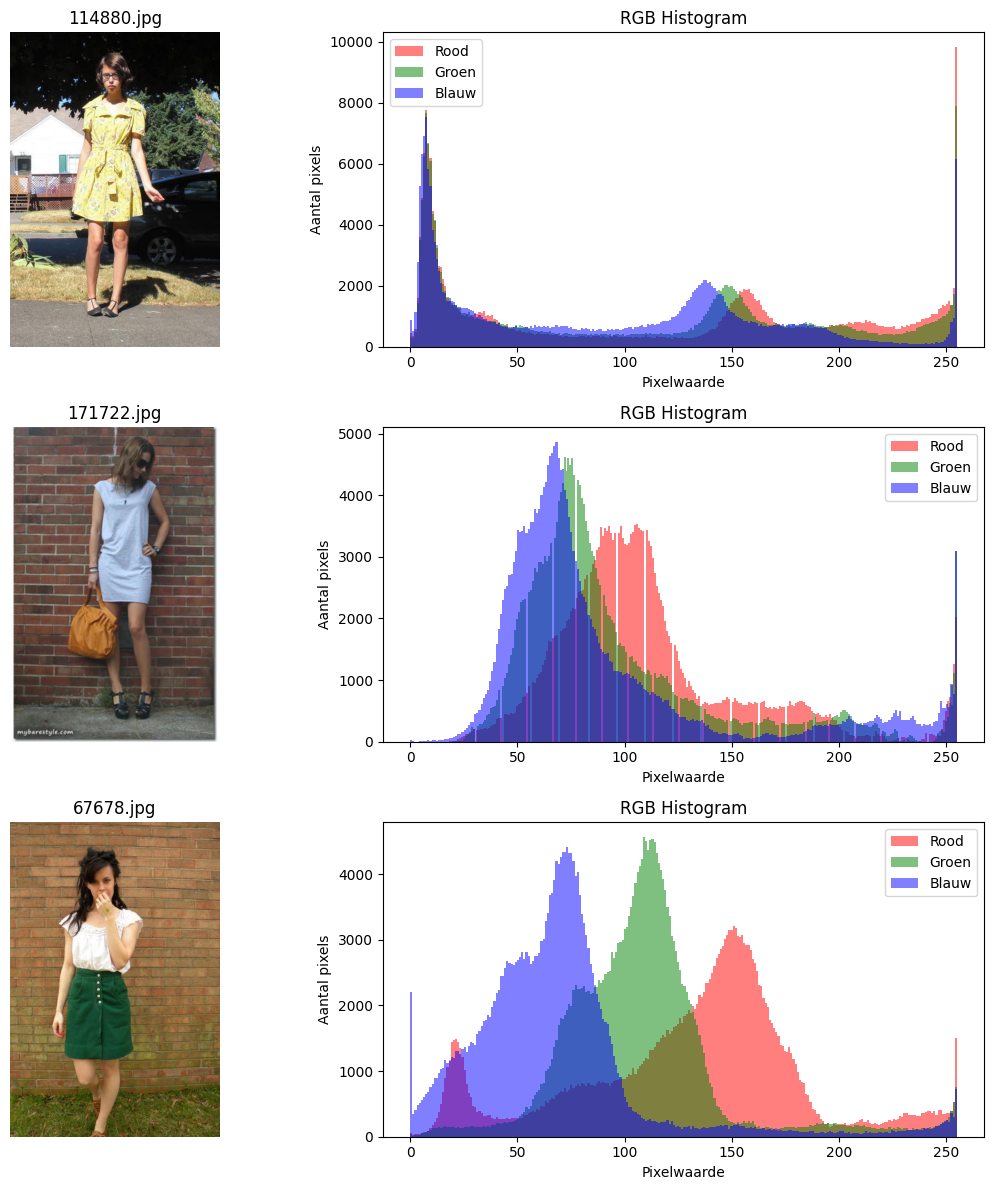

In [78]:
toon_images_met_histogram(img, aantal=3)


### Afbeeldingen met labels

In [19]:
def toon_meerdere_afbeeldingen_met_bboxes(images_dir, labels_dir, class_dict, aantal=3):
    # Kies willekeurige afbeeldingen
    alle_afbeeldingen = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    gekozen_afbeeldingen = random.sample(alle_afbeeldingen, min(aantal, len(alle_afbeeldingen)))

    plt.figure(figsize=(6 * aantal, 6))

    for idx, gekozen_afb in enumerate(gekozen_afbeeldingen):
        naam_zonder_ext = os.path.splitext(gekozen_afb)[0]
        label_pad = os.path.join(labels_dir, f"{naam_zonder_ext}.txt")
        image_pad = os.path.join(images_dir, gekozen_afb)

        # Laad de afbeelding
        img = cv2.imread(image_pad)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # Lees labelbestand en teken bounding boxes
        if os.path.exists(label_pad):
            with open(label_pad, 'r') as f:
                for line in f:
                    delen = line.strip().split()
                    class_id = int(delen[0])
                    cx, cy, bw, bh = map(float, delen[1:])

                    x1 = int((cx - bw / 2) * w)
                    y1 = int((cy - bh / 2) * h)
                    x2 = int((cx + bw / 2) * w)
                    y2 = int((cy + bh / 2) * h)

                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(img, class_dict[class_id], (x1, y1 - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Plot afbeelding
        plt.subplot(1, aantal, idx + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(gekozen_afb)

    plt.tight_layout()
    plt.show()

# Klassen (voorbeeld)
class_dict = {
    0: "sunglass", 1: "hat", 2: "jacket", 3: "shirt", 4: "pants",
    5: "shorts", 6: "skirt", 7: "dress", 8: "bag", 9: "shoe"
}




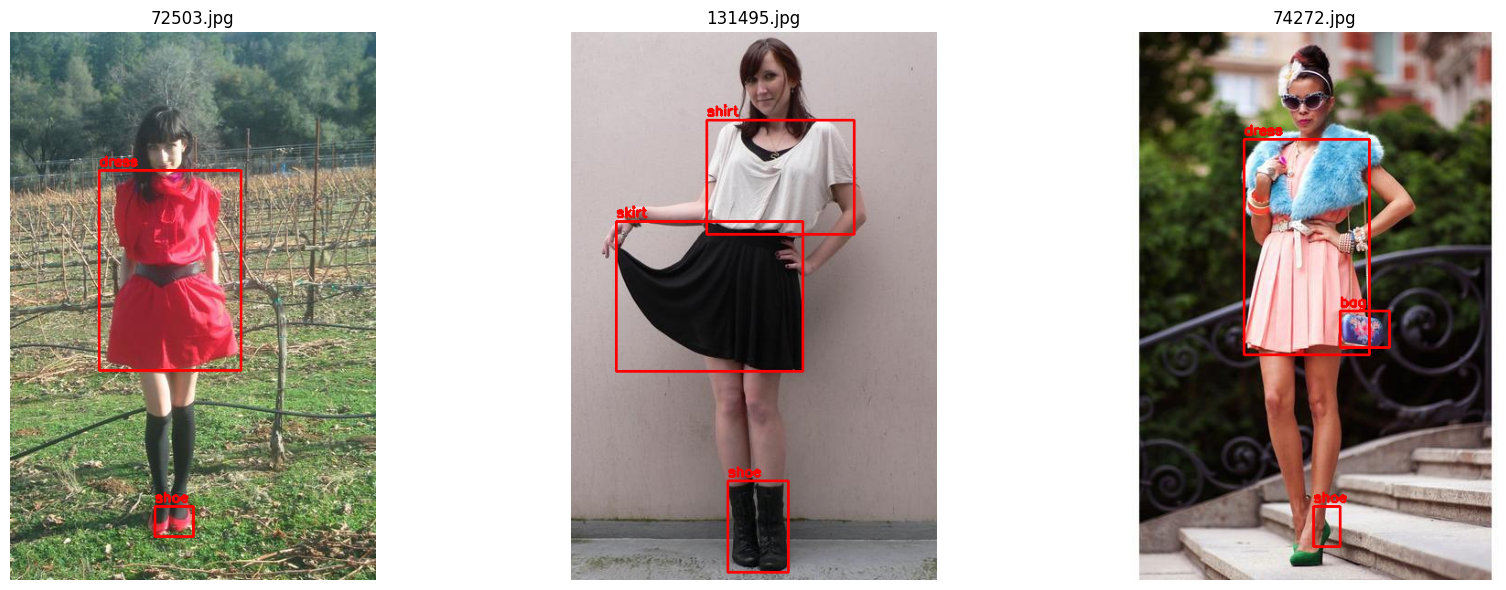

In [21]:
# Gebruik:
labels_dir = img_train + '/labels'
toon_meerdere_afbeeldingen_met_bboxes(images_dir, labels_dir, class_dict, aantal=3)

### De klassenverdeling in de labels

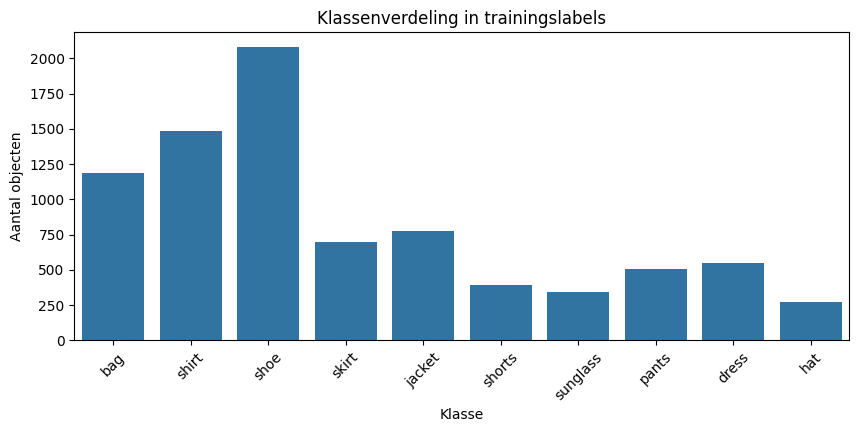

In [22]:
from collections import Counter

def analyseer_klassenverdeling(label_dir):
    counter = Counter()
    for lbl in os.listdir(label_dir):
        if lbl.endswith(".txt"):
            with open(os.path.join(label_dir, lbl), 'r') as f:
                for line in f:
                    class_id = int(line.strip().split()[0])
                    counter[class_id] += 1
    return counter

# Gebruik de functie:
label_dir = "/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Train/labels"
verdeling = analyseer_klassenverdeling(label_dir)

# Visualiseren
import seaborn as sns
plt.figure(figsize=(10, 4))
sns.barplot(x=[class_dict[k] for k in verdeling.keys()], y=list(verdeling.values()))
plt.title("Klassenverdeling in trainingslabels")
plt.ylabel("Aantal objecten")
plt.xlabel("Klasse")
plt.xticks(rotation=45)
plt.show()


## Feature Engineering

## Modeling

### Objectdetectie

### Ondertiteling van afbeeldinge

### Beeldgeneratie

### Implementatie

### Scoren:

|Model|Notebook|Kaggle|
|----|------|------|
||||
||||
||||
||||

#### Bevindingen modellen

## Conclusion & Advice

## Sources

### Submission functie

In [ ]:
def create_submission(pred, df_test, filename, label_encoder):
    """
    Creates a submission file for Kaggle test data with genre predictions.

    Args:
        pred (np.ndarray): Predicted probabilities or class indices.
        df_test (pd.DataFrame): Test dataframe containing filenames.
        filename (str): Output CSV filename (must include .csv).
        label_encoder (LabelEncoder): Trained label encoder to decode genre indices.

    Returns:
        pd.DataFrame: Submission dataframe.
    """
    # Als pred probabilities bevat → neem hoogste waarschijnlijkheid
    if pred.ndim > 1 and pred.shape[1] > 1:
        pred_classes = np.argmax(pred, axis=1)
    else:
        pred_classes = pred.reshape(-1)

    # Decode genre-namen
    genre_labels = label_encoder.inverse_transform(pred_classes[:len(df_test)])

    # Maak het submission DataFrame
    submission_df = pd.DataFrame({
        'filename': df_test['filename'].values[:len(genre_labels)],
        'genre': genre_labels
    })

    # Sla op
    submission_df.to_csv(filename, index=False)

    return submission_df


In [ ]:
# create_submission(y_pred, df_test, 'test.csv', le)

,filename,genre
0,test.00000.wav,rock
1,test.00001.wav,country
2,test.00002.wav,pop
3,test.00003.wav,blues
4,test.00004.wav,country
...,...,...
124,test.00124.wav,reggae
125,test.00125.wav,country
126,test.00126.wav,hiphop
127,test.00127.wav,country


### Html

In [ ]:
# Upload ipynb
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")

Saving Portfolio_1.ipynb to Portfolio_1.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>